In [70]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,6
#Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [71]:
path = "./datasets/"
#check location of files
os.getcwd()

'/Users/vishalpattanshetty/USF/GitHub/pft/scripts'

In [72]:

weekly = pd.read_csv("/Users/vishalpattanshetty/USF/GitHub/pft/submission/datasets/structuralweekly_with_indicators.csv")

In [73]:
weekly.calendar_day = weekly.calendar_day.astype('datetime64')

In [74]:
# Splitting by years with uneven data points per year
# Source: https://stackoverflow.com/questions/58069691/how-to-create-a-train-test-split-of-time-series-data-by-year
year_list = weekly['year'].unique().tolist()
weekly_splits = {'train': [], 'test': []}

for idx, yr in enumerate(year_list[:-1]):
    train_yr = year_list[:idx+1]
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    weekly_splits['train'].append(weekly.loc[weekly.year.isin(train_yr), :])
    weekly_splits['test'].append(weekly.loc[weekly.year.isin(test_yr), :])

print('\n')
# Exception, we only have 3 series (2019 + 2020) should be aggregated(if 2020 is used)
print("Size of the Train-Test Splits:")
print("Train 2016-18:",weekly_splits['train'][2].shape[0])
print("Test  2019-20:",weekly_splits['test'][2].shape[0]+weekly_splits['test'][3].shape[0])

TRAIN:  [2016] TEST:  [2017]
TRAIN:  [2016, 2017] TEST:  [2018]
TRAIN:  [2016, 2017, 2018] TEST:  [2019]
TRAIN:  [2016, 2017, 2018, 2019] TEST:  [2020]


Size of the Train-Test Splits:
Train 2016-18: 9455
Test  2019-20: 3064


In [75]:
train = weekly_splits['train'][2]
test = weekly_splits['test'][2].append(weekly_splits['test'][3], ignore_index=True)

In [76]:
#filtering block for analysis
train_block = train[train['block']=='4" ANG']
test_block = test[test['block']=='4" ANG']
#size decreases significantly - this could help/hurt
train_block.shape

(157, 18)

In [77]:
train_block.head()

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
16,2016-01-03,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",719.151,0,0.000,0
76,2016-01-10,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",13147.336,3607,476.854,297
112,2016-01-17,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",17879.528,0,620.538,937
166,2016-01-24,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",14607.058,0,203.390,392
191,2016-01-31,2016,1,0.66,1583,16684,204300,30800,175300,38700,48.2,53.5,180,"4"" ANG",12144.329,1,455.771,696


In [78]:
test_block.head()

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
21,2019-01-06,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",4262.897998,-24,159.2460,53
85,2019-01-13,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",5933.199996,0,99.4880,120
163,2019-01-20,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",9409.983072,4038,66.6380,190
213,2019-01-27,2019,1,0.7768,1601,18166,222800,34800,201600,34200,56.6,56.7,375,"4"" ANG",29326.198250,1680,484.3780,296
249,2019-02-03,2019,2,0.7915,1785,18809,201900,30500,175600,30900,54.2,59.7,355,"4"" ANG",39356.174170,49,1174.3135,875


In [79]:
train_block = train_block[['calendar_day', 'shipment_tons']]

In [80]:
test_block = test_block[['calendar_day', 'shipment_tons']]

In [81]:
train_block=train_block.set_index('calendar_day')
test_block=test_block.set_index('calendar_day')

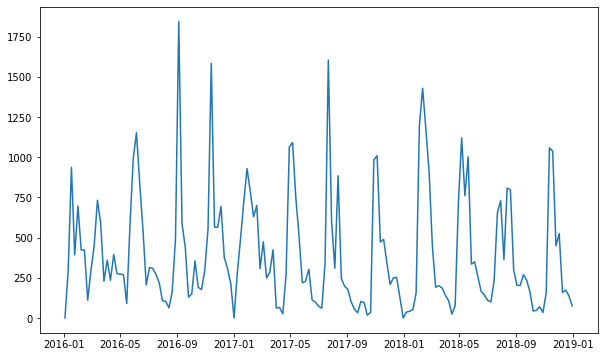

In [82]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(train_block)

In [83]:
#to check if the data is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

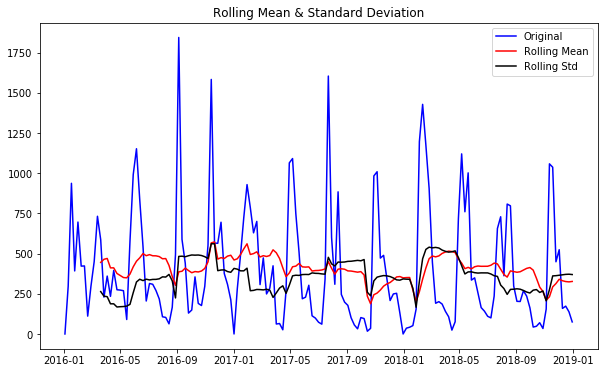

Results of Dickey-Fuller Test:
Test Statistic                -7.561664e+00
p-value                        2.998821e-11
#Lags Used                     7.000000e+00
Number of Observations Used    1.490000e+02
Critical Value (1%)           -3.475018e+00
Critical Value (5%)           -2.881141e+00
Critical Value (10%)          -2.577221e+00
dtype: float64


In [84]:
test_stationarity(train_block)

In [85]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_block, nlags=20)
lag_pacf = pacf(train_block, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

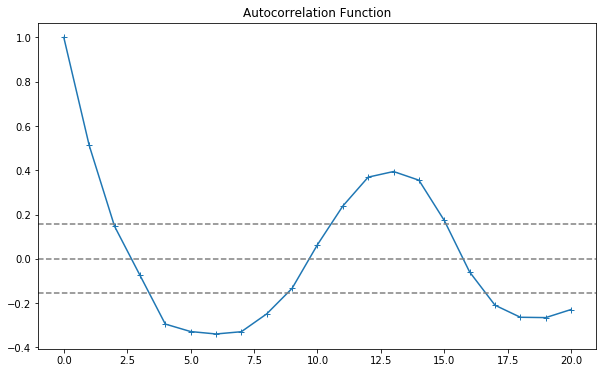

In [86]:
#Plot ACF: 
#plt.subplot(121) 
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

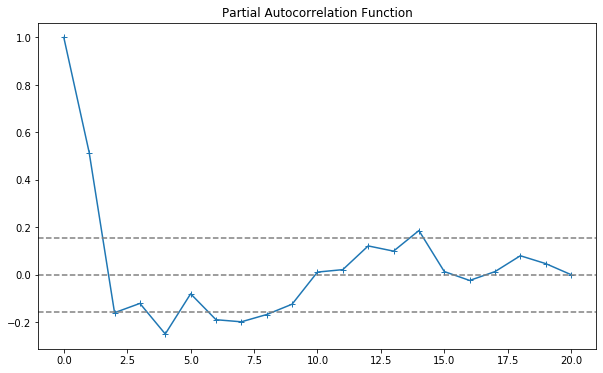

In [87]:
#Plot PACF:
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_block)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 14659488.2401')

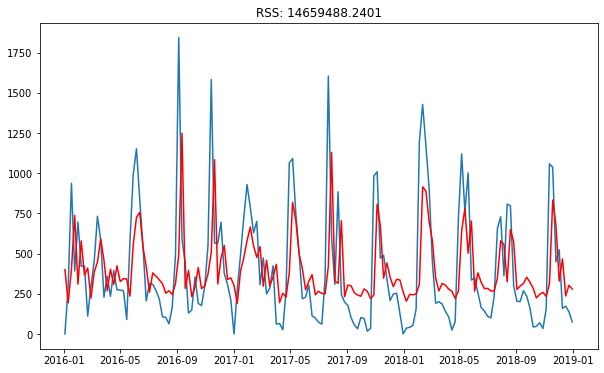

In [88]:
# ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train_block, order=(2,0,2))  
results_AR = model.fit(disp=-1)  
plt.plot(train_block)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_block['shipment_tons'])**2))

In [90]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

calendar_day
2016-01-03    400.399229
2016-01-10    193.605454
2016-01-17    401.957409
2016-01-24    737.809955
2016-01-31    310.382223
dtype: float64


Text(0.5, 1.0, 'RMSE: 305.5692')

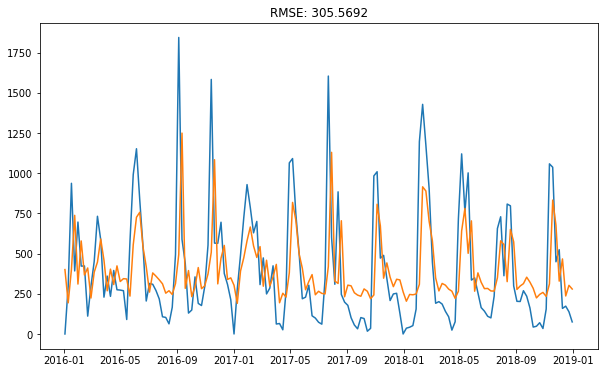

In [92]:
plt.plot(train_block)
plt.plot(predictions_ARIMA_diff)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_diff-train_block['shipment_tons'])**2)/len(train_block['shipment_tons'])))

In [103]:
y_pred=results_AR.predict(start='2019-01-06', end='2020-01-05')